In [137]:
!pip install torchtext==0.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [138]:
import torch
from torchtext import data
from torchtext import datasets

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy', tokenizer_language='en_core_web_sm', include_lengths = True)
LABEL = data.LabelField(dtype=torch.LongTensor)  # Changed dtype to LongTensor


In [139]:
import pandas as pd

In [140]:
df = pd.read_csv('balanced_task2.csv')   

In [141]:
len(df)

2136

In [142]:
df.head()

,Unnamed: 0,text,class
0,664,Netanyahu barely scratches out a victory in Is...,0
1,61,"In ""Hunters,"" the premiere episode of a new se...",0
2,518,. cricket ice cream is a luxury ice cream made...,0
3,248,Graciela Iturbide was born in Mexico City in 1...,0
4,435,A new study from the University of Rochester d...,0


In [143]:
df[['Generation']] = df[['text']]. astype(str)

In [144]:
df = df[['Generation','class']]

In [145]:
# text_field = data.Field(
#     sequential=True,
#     tokenize='basic_english', 
#     fix_length=500,
#     lower=True
# )

TEXT = data.Field(tokenize = 'spacy', tokenizer_language='en_core_web_sm', include_lengths = True)
LABEL = data.LabelField(sequential=False, use_vocab=False, dtype = torch.float)

# label_field = data.Field(sequential=False, use_vocab=False)

# sadly have to apply preprocess manually
preprocessed_text = df['Generation'].apply(
    lambda x: TEXT.preprocess(x)
)

# load fastext simple embedding with 300d
TEXT.build_vocab(
    preprocessed_text, 
    max_size = 30000,
    vectors='glove.6B.50d',
    unk_init = torch.Tensor.normal_
)

# get the vocab instance
vocab = TEXT.vocab


In [146]:
ltoi = {l: i for i, l in enumerate(df['class'].unique())}

In [147]:
df['label1'] = df['class'].apply(lambda y: ltoi[y])

class DataFrameDataset(data.Dataset):
    def __init__(self, df: pd.DataFrame, fields: list):
        super(DataFrameDataset, self).__init__(
            [
                data.Example.fromlist(list(r), fields) 
                for i, r in df.iterrows()
            ], 
            fields
        )

In [148]:
df1=df[['Generation','label1']]

In [149]:
examples=[]
for i,row in df1.iterrows():
  # print(example)
  examples.append(data.Example.fromlist(row, fields=[('text', TEXT), ('label', LABEL)]))

In [150]:
# examples[2000].label
c=0
for i in examples:
  if type(i.label) != int:
    c+=1

In [151]:
c

0

In [152]:
dataset = data.Dataset(examples, fields=[('text', TEXT), ('label', LABEL)])

In [153]:
train_dataset, test_dataset, valid_dataset = dataset.split(split_ratio=[0.65, 0.15, 0.2], stratified=True, strata_field='label')
     

In [154]:
len(train_dataset)

1389

In [155]:
ltoi

{0: 0, 1: 1}

In [156]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("We are working with ", device)
# device = 'cpu'
train_iter, test_iter, valid_iter = data.BucketIterator.splits(
    datasets=(train_dataset, test_dataset, valid_dataset), 
    batch_size=32,
    sort_within_batch = True,
    sort_key=lambda x: len(x.text),
    device=device
)
  

We are working with  cpu


In [157]:
import torch.nn as nn
import torch.nn.functional as F

class StackedCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout, pad_idx):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [sent len, batch size]
        
        text = text.permute(1, 0)
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        #conv_n = [batch size, n_filters, sent len - filter_sizes[n]]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)



In [158]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 50
OUTPUT_DIM = 2
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
N_FILTERS = 100
FILTER_SIZES = [3,4,5]

model = StackedCNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [159]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,561,002 trainable parameters


In [160]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([30002, 50])


In [161]:
model.embedding.weight.data.copy_(pretrained_embeddings)
     

tensor([[-0.1117, -0.4966,  0.1631,  ...,  0.7372,  0.3910,  0.5158],
        [ 0.1825, -0.0737,  0.3147,  ...,  1.3226, -2.6796, -0.1297],
        [ 0.0134,  0.2368, -0.1690,  ..., -0.5666,  0.0447,  0.3039],
        ...,
        [-0.0786,  1.5932, -0.6019,  ..., -2.0051, -0.7769, -0.5551],
        [-0.1020, -0.0747, -1.2522,  ..., -0.4305,  0.2201, -0.3715],
        [ 0.0684,  2.0036, -0.2504,  ...,  1.1077,  2.4547,  0.1748]])

In [162]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0134,  0.2368, -0.1690,  ..., -0.5666,  0.0447,  0.3039],
        ...,
        [-0.0786,  1.5932, -0.6019,  ..., -2.0051, -0.7769, -0.5551],
        [-0.1020, -0.0747, -1.2522,  ..., -0.4305,  0.2201, -0.3715],
        [ 0.0684,  2.0036, -0.2504,  ...,  1.1077,  2.4547,  0.1748]])


In [163]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

In [164]:
criterion = nn.CrossEntropyLoss()

# device='cpu'
model = model.to(device)
criterion = criterion.to(device)

In [165]:
def multiclass_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    # get the index of the highest prediction for each instance
    _, preds = torch.max(preds, dim=1)
    correct = (preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [166]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, _ = batch.text  # We are not using text_lengths
        
        predictions = model(text).squeeze(1)  # Only pass text to the model

        target = batch.label
        target = target.type(torch.LongTensor)

        loss = criterion(predictions.to(device), target.to(device))
        
        acc = multiclass_accuracy(predictions, batch.label)
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [167]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:
            
            text, _ = batch.text  # We are not using text_lengths
            
            predictions = model(text).squeeze(1)  # Only pass text to the model
            target = batch.label
            target = target.type(torch.LongTensor)
            
            loss = criterion(predictions.to(device), target.to(device))
            
            acc = multiclass_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [168]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [169]:
train_losses_list = []
valid_losses_list = []
train_accs=[]
valid_accs=[]

In [170]:
N_EPOCHS = 25
path = "stackedCNN_model_task2.pt"
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iter, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iter, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    train_losses_list.append(train_loss)
    valid_losses_list.append(valid_loss)
    train_accs.append(train_acc*100)
    valid_accs.append(valid_acc*100)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), path)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 48s
	Train Loss: 0.790 | Train Acc: 57.39%
	 Val. Loss: 1.049 |  Val. Acc: 50.00%
Epoch: 02 | Epoch Time: 0m 38s
	Train Loss: 0.660 | Train Acc: 63.90%
	 Val. Loss: 0.522 |  Val. Acc: 81.56%
Epoch: 03 | Epoch Time: 0m 38s
	Train Loss: 0.567 | Train Acc: 69.53%
	 Val. Loss: 0.468 |  Val. Acc: 76.56%
Epoch: 04 | Epoch Time: 0m 37s
	Train Loss: 0.362 | Train Acc: 85.16%
	 Val. Loss: 0.373 |  Val. Acc: 82.50%
Epoch: 05 | Epoch Time: 0m 37s
	Train Loss: 0.290 | Train Acc: 88.64%
	 Val. Loss: 0.329 |  Val. Acc: 86.25%
Epoch: 06 | Epoch Time: 0m 37s
	Train Loss: 0.236 | Train Acc: 92.40%
	 Val. Loss: 0.327 |  Val. Acc: 84.06%
Epoch: 07 | Epoch Time: 0m 37s
	Train Loss: 0.194 | Train Acc: 93.54%
	 Val. Loss: 0.296 |  Val. Acc: 86.88%
Epoch: 08 | Epoch Time: 0m 37s
	Train Loss: 0.167 | Train Acc: 94.53%
	 Val. Loss: 0.280 |  Val. Acc: 87.50%
Epoch: 09 | Epoch Time: 0m 37s
	Train Loss: 0.137 | Train Acc: 95.67%
	 Val. Loss: 0.289 |  Val. Acc: 87.19%
Epoch: 10 | Epoch T

In [171]:
test_loss, test_acc = evaluate(model, test_iter, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.346 | Test Acc: 89.53%


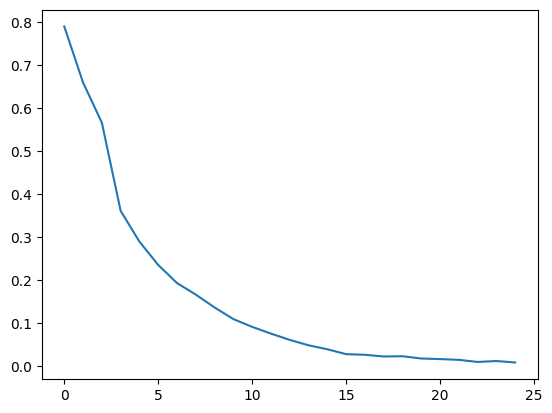

In [172]:
import matplotlib.pyplot as plt

plt.plot(train_losses_list)

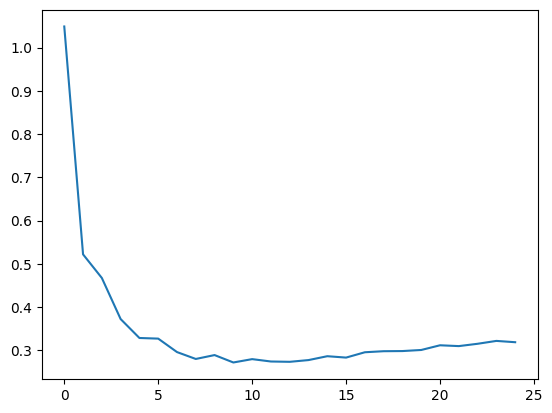

In [173]:
plt.plot(valid_losses_list)

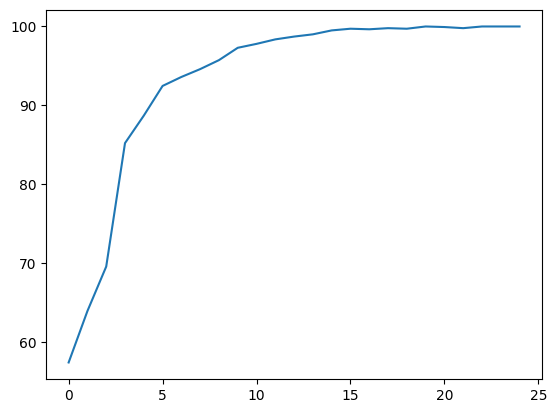

In [174]:
plt.plot(train_accs)
     

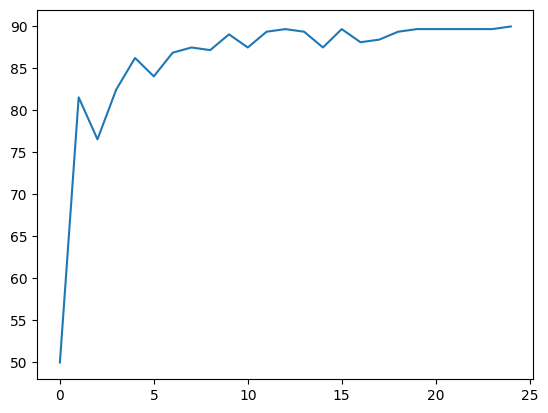

In [175]:
plt.plot(valid_accs)

In [188]:
def dataframetodataset(df):
  examples=[]
  for i,row in df.iterrows():
    # print(example)
    examples.append(data.Example.fromlist(row, fields=[('text', TEXT), ('label', LABEL)]))
    dataset = data.Dataset(examples, fields=[('text', TEXT), ('label', LABEL)])
    # train_dataset, test_dataset, valid_dataset = dataset.split(split_ratio=[0.4, 0.3, 0.3], stratified=True, strata_field='label')
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # print("We are working with ", device)
    # train_iter, test_iter, valid_iter = data.BucketIterator.splits(
    #     datasets=(train_dataset, test_dataset, valid_dataset), 
    #     batch_size=16,
    #     sort_within_batch = True,
    #     sort_key=lambda x: len(x.text),
    #     device=device
    # )
  return dataset#,train_iter,test_iter,valid_iter

# **Reddit Data Evaluation**

In [189]:
import pandas as pd


In [190]:
reddit_df = pd.read_csv('reddit_data.csv')

In [191]:
reddit_df.head()

,Unnamed: 0,Title,Body,Generated Text
0,0,META: Fresh Topic Friday,[Every Friday](https://www.reddit.com/r/change...,NaN
1,1,"CMV: Demanding ""Asian people"" to have better g...",Edit:I talk about the fact that Asian applican...,NaN
2,2,CMV: Eating your lunch on the toilet is a disg...,I have a coworker who does this and it's prett...,NaN
3,3,"cmv: I don’t see transwomen as women, but don’...","Now, I don’t have any sort of hate towards tra...",NaN
4,4,CMV: there is nothing sinister or underhanded ...,I think ghost kitchens are just the inevitable...,NaN


In [192]:
reddit_df = reddit_df[['Title']]

In [193]:
reddit_df['label']=0
     

In [194]:
len(reddit_df)

601

In [195]:
dataset = dataframetodataset(reddit_df)
     

In [196]:
dataset.fields

{'text': <torchtext.data.field.Field at 0x7f0edc266380>,
 'label': <torchtext.data.field.LabelField at 0x7f0ec5fab310>}

In [197]:
train_dataset, test_dataset, valid_dataset = dataset.split(split_ratio=[0.4, 0.3, 0.3], stratified=True, strata_field='label')
 

In [198]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("We are working with ", device)
train_iter, test_iter, valid_iter = data.BucketIterator.splits(
    datasets=(train_dataset, test_dataset, valid_dataset), 
    batch_size=16,
    sort_within_batch = True,
    sort_key=lambda x: len(x.text),
    device=device
)

We are working with  cpu


In [199]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 50
OUTPUT_DIM = 2
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
N_FILTERS = 100
FILTER_SIZES = [3,4,5]

model = StackedCNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [200]:
# model = torch.load(path)
model.load_state_dict(torch.load(path))


# Set the model to evaluation mode
# model.eval()
model = model.to(device)

In [201]:
evaluate(model, test_iter, criterion)

(0.22117969393730164, 0.9635416666666666)

In [202]:
evaluate(model, valid_iter, criterion)

(0.2437458566079537, 0.9479166666666666)

In [203]:
evaluate(model, train_iter, criterion)

(0.2307396948337555, 0.9666666666666667)